# Churn Prediction for KKBox

KKBox is a subscription based music company based out of Taiwan. The goal is to predict whether the user will churn or resubscribe to their service. 

For a subscription business, accurately predicting churn is critical to long-term success. Even slight variations in churn can drastically affect profits.

KKBOX is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This delicate model is dependent on accurately predicting churn of their paid users.

Data is available at: https://www.kaggle.com/c/kkbox-churn-prediction-challenge

Data Description

1. train.csv
the train set, containing the user ids and whether they have churned.

msno: user id
is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. 
is_churn = 1 means churn,is_churn = 0 means renewal.

2. transactions.csv

transactions of users up until 2/28/2017.

msno: user id

payment_method_id: payment method

payment_plan_days: length of membership plan in days

plan_list_price: in New Taiwan Dollar (NTD)

actual_amount_paid: in New Taiwan Dollar (NTD)

is_auto_renew

transaction_date: format %Y%m%d

membership_expire_date: format %Y%m%d

is_cancel: whether or not the user canceled the membership in this transaction.

3. user_logs.csv

daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.

msno: user id

date: format %Y%m%d

num_25: # of songs played less than 25% of the song length

num_50: # of songs played between 25% to 50% of the song length

num_75: # of songs played between 50% to 75% of of the song length

num_985: # of songs played between 75% to 98.5% of the song length

num_100: # of songs played over 98.5% of the song length

num_unq: # of unique songs played

total_secs: total seconds played

4. members.csv

user information. Note that not every user in the dataset is available.

msno

city

bd: age

gender

registered_via: registration method

registration_init_time: format %Y%m%d

expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual 
churn behavior.




# Business Question
In this project we were tasked to build an algorithm that predicts whether a user will churn after their subscription expires. 

# Loading all the necessary libraries

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score,f1_score,precision_score,confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random


# Loading the functions for effective use ahead

The function below prints an image for confusion matrix for better understanding

code taken from: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

In [2]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Loading the members data

In [3]:
members = pd.read_csv('Downloads/members_v3.csv')
#There are 65% null values for gender, hence we will be dropping the gender column
members.drop('gender',axis=1,inplace=True)
#changing name of the age column
members=members.rename(columns = {'bd':'age'})

Cites are numbered, hence converting them in to nominal variables

In [4]:
members.city =members.city.astype('category')
members.registered_via =members.registered_via.astype('category')

In [5]:
members.head()

,msno,city,age,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,9,20110915


The variable age has a lot of missing, 0 and greater than 99 values which would be bad data. Hence, counting the total number of such values

In [6]:
len(members[(members['age']==0) | (members['age']>99)])/len(members)

0.671505004894768

In [7]:
#Since 67% of the members have ages which do not make sense, I am removing the age column
members.drop('age',axis=1,inplace=True)

Loading the train.csv and the transaction data

In [8]:
train = pd.read_csv('Downloads/train_v2.csv')

In [9]:
train.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [10]:
transaction = pd.read_csv('Downloads/transactions_v2.csv')


In [11]:
transaction.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


In [12]:
transaction.shape

(1431009, 9)

We wanted to check the correlation between the list price and the actual amount paid as i thought these two columns will be highly correlated. Hence, instead of checking for the correlation, i checked how manly values are the exact same

In [13]:
#Counting the number of values that are similar between plan_list_price and actual_amount_paid
len(transaction[transaction.plan_list_price==transaction.actual_amount_paid])/len(transaction)

0.9916820928449787

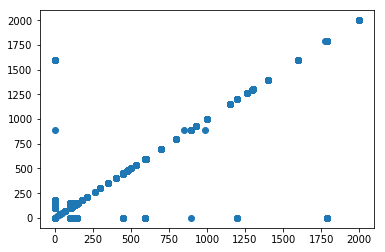

In [14]:
#High correlation between actual_amount_paid and plan_list_price
plt.scatter(transaction['actual_amount_paid'],transaction['plan_list_price'])

In [15]:
#Since more than 99% of the plan_list_price == actual_amount_paid, removing the actual_amount_paid column
transaction.drop('actual_amount_paid',axis=1,inplace=True)

In [16]:
#Converting payment_method_id to categorical variable (Nominal)
transaction.payment_method_id = transaction.payment_method_id.astype('category')

# Binning highly discretized data

The column payment plan days has a lot of different values. Hence, we decided to bin that data to have lesser data and to group the data which were close to each other 


In [17]:
transaction.payment_plan_days.value_counts().sort_index()

0         2218
1          676
3            9
7        12168
10         416
14          82
21          11
30     1217998
31           4
35          29
45          41
60        3134
70          49
80          43
90       19130
100       4098
110         20
120       3612
180      23900
195      28568
200       3108
230         35
240       3440
270        997
360       4658
365       3838
395       9753
400       1817
410      82097
415       3298
450       1762
Name: payment_plan_days, dtype: int64

As you can see the payment_plan_days has a lot of plans. Binning this into fewer bins will help during the process of modelling and also to understand customer behaviour

In [18]:
transaction['payment_plan_days_bins'] = 0

In [ ]:
#binning for payment_plan_days
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] <4)] =  '3 day or lesser'
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] ==7)] =  '1 week'
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] >7)&(transaction['payment_plan_days'] <22)] =  '1-3week'
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] >29)&(transaction['payment_plan_days'] <32)] = '1 month'
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] >32)&(transaction['payment_plan_days'] <91)] = '1-3 months'
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] >91)&(transaction['payment_plan_days'] <121)] = '3-4 months'
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] ==180)|(transaction['payment_plan_days'] ==195)] =  '6months'
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] >180)&(transaction['payment_plan_days'] <271)] = '6-9 months'
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] >359)&(transaction['payment_plan_days'] <366)] = '1 year'
transaction['payment_plan_days_bins'][(transaction['payment_plan_days'] >366)] =  '1 year or more'

A few models (like xgboost) do not work well with strings. Hence we decided to change the stings to number. We played around with both the facts - the numbers are ordered, they arent ordered. The accuracy changed only a little

In [ ]:
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='3 day or lesser')] =1
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='1 week')]=2
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='1-3week')]=3
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='1 month')]=4
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='1-3 months')]=5
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='3-4 months')]=6
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='6months')]=7
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='6-9 months')]=8
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='1 year')]=9
transaction['payment_plan_days_bins'][(transaction['payment_plan_days_bins']=='1 year or more')]=10
transaction.payment_plan_days_bins.dtype

Converting payment plan days bins columns into category and nominal

In [21]:
transaction.payment_plan_days_bins = transaction.payment_plan_days_bins.astype('category')

In [22]:
transaction.payment_plan_days_bins.dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ordered=False)

Loading the user logs file

In [23]:
user_logs = pd.read_csv('Downloads/user_logs_v2.csv')

In [24]:
user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


The date column has data for one month

In [25]:
user_logs.date.nunique()

31

Calculating total number of unique users

In [26]:
user_logs.drop('date',axis=1,inplace=True)

In [27]:
user_logs.msno.nunique()

1103894

Here total number of unnique users are roughly a million. 
The user_logs data gives us data about these users listening habit for that month on each day.

Hence to accommdate the above fact, we decided to take the mean of the logs of that user for that month. 
We also tried mean and the sum.
After doing this step, each user had one row telling on average how did the use their application

In [28]:
logs = user_logs.groupby('msno').mean()

In [29]:
logs['msno'] = logs.index

In [30]:
logs.index = range(len(logs))

In [31]:
logs.head()

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,msno
0,3.307692,0.423077,0.384615,0.192308,18.153846,20.384615,4534.900962,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=
1,6.161290,2.903226,2.419355,4.645161,19.000000,28.548387,6210.577161,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=
2,1.535714,0.428571,0.535714,0.428571,17.321429,16.714286,4121.830714,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=
3,9.857143,7.761905,4.761905,3.047619,20.761905,39.428571,7137.931333,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=
4,3.620690,0.827586,1.344828,1.206897,16.517241,7.931034,4014.939552,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=


# Merging all the data frames
After initially doing the preprocessing on all the dataframes,for the final model, we will be merging all the dataframes to use various attributes

In [32]:
data = train.merge(transaction, on='msno',how='left').merge(logs, on='msno',how='left').merge(members, on='msno',how='left')

In [33]:
data.dropna().shape

(890959, 20)

In [34]:
data.dropna(inplace=True)

In [35]:
#Final Columns that are in the data dataframe
data.columns

Index(['msno', 'is_churn', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel', 'payment_plan_days_bins',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'city', 'registered_via', 'registration_init_time'],
      dtype='object')

In [36]:
#Converting the city variable in into nominal qualitative varaible (as explained above)
data.city = data.city.astype('category')

# Machine Learning

Here we are dividing the target variables and the predictor variables into y and x respectively. We are dropping the variables which we arent going to use in our analysis

In [37]:

X = data.drop(['msno','is_churn','registration_init_time',  'payment_method_id','registered_via','transaction_date', 'is_cancel','membership_expire_date', 'payment_plan_days'],axis=1)
y=data.is_churn

# Random Forest

After a using a few models like logistic regression, decision trees and random forest, we found random forest to be the best:
1. The best accuracy (Area under the curve as well)
2. It gave us the opportunity to understand the feature importance 
3. Looking at the decision node, we could tell what features are triggering the user to leave and immediate attention could be given to that

# Parameters of Random Forest
1. n_jobs=-1 - This allows the algorithms to run parallely on various CPU's on the device
2. min_sample_splits= 2 -Minimum number of samples required to split a node
3. min_samples_leaf  =1 -  Minimum number of samples required in leaf node
4. max_features = 0.8 -  Number of features to consider at every split (helps to eliminate the variance)
5. class_weight = 'balanced' - Take same number of 0,1 from the target variables
6. n_estimators = 100 - 100 trees to be created

In [38]:
model = RandomForestClassifier(n_jobs=-1,
                               min_samples_split=2, 
                               min_samples_leaf=1, 
                               max_features=0.8,
                               class_weight='balanced',
                               n_estimators=100) #100 and 500 doesnt have much difference

Splitting the data into traning and testing set. This helps us to test our model on the data it hasnt quite seen yet

In [39]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.1)

In [40]:
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [41]:
preds = model.predict(X_test)

In [42]:
#how well does your model do in terms of the overall accuracy
accuracy_score(y_test,preds)

0.9769349914698752

Since this is an imbalanced dataset, looking only at the accuracy will lead to bad model and making bad decisions.

Also, it is really important to focus on the recall as we want to capture the subscribers who might leave as early as possible to give them the right promotions to keep them on the platform

In [43]:
recall_score(y_test,preds)

0.7624706027973759

In [44]:
precision_score(y_test,preds)

0.9783989834815756

In [45]:
roc_auc_score(y_test,preds)

0.880395971381531

# Feature Importance
One of the best features about random forest is that we can analyze the feature importance. 

It gives us insights in terms of what attribues contribute towards a user churning or staying on the platform 

This will help KKBOX to focus on understanding what the users are looking for on their platform

In [46]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_test.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
#importances.sort_values(by='Gini-importance',ascending=False)
importances[importances['Gini-importance']>0].sort_values(by='Gini-importance',ascending=False)

,Gini-importance
is_auto_renew,0.124497
total_secs,0.118595
num_unq,0.115650
num_25,0.113316
num_100,0.098915
num_50,0.098418
num_985,0.095508
num_75,0.094114
payment_plan_days_bins,0.049453
city,0.047915


1. is_auto_renew - This would tell us whether the user has kept the auto renew features on or not. This is important because a user who has auto renew on is happy with the service and wouldnt mind continuing it. This is opposed to the user who maybe isnt sure about continuing. 
2. totla_secs - This attributes talks about how long did that user on average used the service. This is an important parameter which will tell us the difference between the user who is using the service and is liking it and the user who doesnt use the service and is likely to churn soon 
3. num_unq - This attribute talks about how many unique songs on an average the user listens to in a day. This attirubte could tell us if the user is happy with range of song selection that kkbox provides and it could be a useful insights

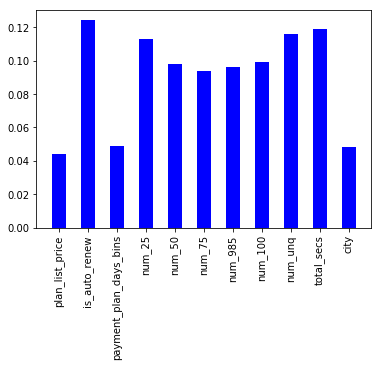

<Figure size 432x288 with 0 Axes>

In [47]:
#Here we are plotting the features imporance for visual analysis
feature = []
value = []
for f,v in feats.items():
    feature.append(f)
    value.append(round(v,3))
#importances['Gini-importance']
feature
value

fig = plt.figure()
width = 1/2
plt.bar(feature, value, width, color="blue")
plt.xticks(rotation=90)

plt.show()
plt.tight_layout()



#Confusion Matrix

Confusion matrix helps to understand the true and the predicted label of a our model and to understand how much is our model getting it right and how much can it improve

In [48]:
confusion= confusion_matrix(y_test,preds)

As you can see below our model is doing very well in idenitifying the users who will stay. But we are more interested in the users who might churn where the model still can have a lot improvements. 

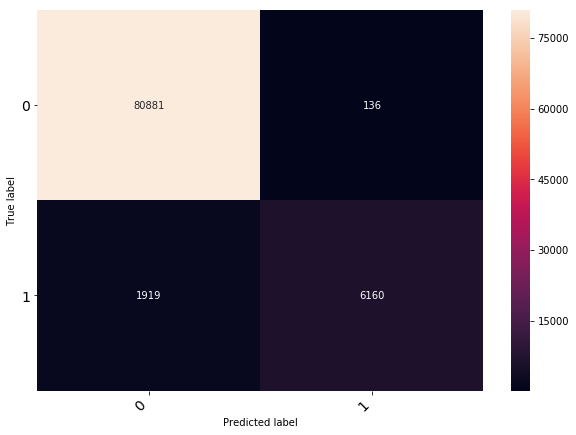

In [49]:
print_confusion_matrix(confusion,[0,1])

# Second Model
Below we are doing the same process as above but with more added columns. 
The columns added were is_cancel (if the user is actively cancelling subscription before it is over) this could help to target the user who is actively cancelling and might not resubscribe again)

In [50]:
X = data.drop(['msno','is_churn','registration_init_time', 'payment_method_id','registered_via','transaction_date','membership_expire_date', 'payment_plan_days'],axis=1)
y=data.is_churn
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.1)
model.fit(X_train,y_train)
preds = model.predict(X_test)

In [51]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_test.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
#importances.sort_values(by='Gini-importance',ascending=False)
importances[importances['Gini-importance']>0].sort_values(by='Gini-importance',ascending=False)

,Gini-importance
is_auto_renew,0.134253
num_unq,0.101667
total_secs,0.100322
num_25,0.099883
is_cancel,0.089102
num_50,0.088197
num_100,0.086599
num_985,0.084734
num_75,0.083707
plan_list_price,0.049221


In [52]:
accuracy_score(y_test,preds)

0.9688650444464398

In [53]:
recall_score(y_test,preds)

0.7086273053595742

In [54]:
precision_score(y_test,preds)

0.9316517493897477

In [55]:
roc_auc_score(y_test,preds)

0.8517216040973908

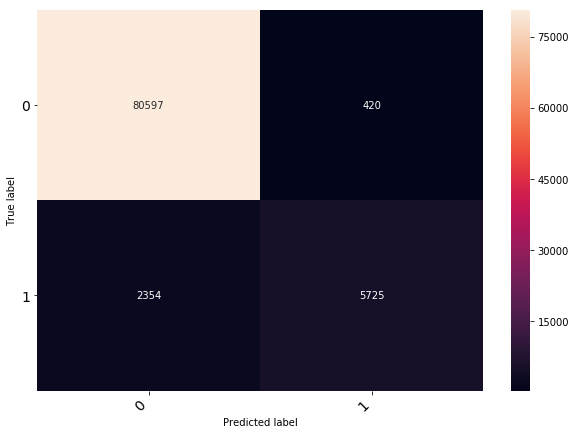

In [56]:
confusion= confusion_matrix(y_test,preds)
print_confusion_matrix(confusion,[0,1])

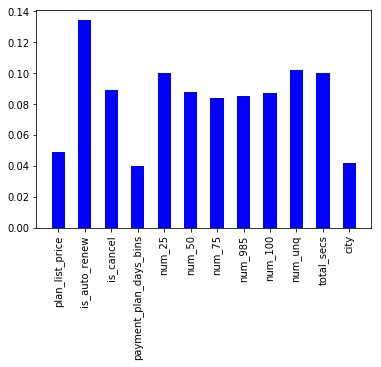

<Figure size 432x288 with 0 Axes>

In [57]:

feature = []
value = []
for f,v in feats.items():
    feature.append(f)
    value.append(round(v,3))
#importances['Gini-importance']
feature
value

fig = plt.figure()
width = 1/2
plt.bar(feature, value, width, color="blue")
plt.xticks(rotation=90)

plt.show()
plt.tight_layout()


# Business Insights from Machine learning Model

After performing the statistical model analysis on the data we have come up with the following analysis

1. KKBOX should focus on the user who have not turned their auto-renew feature on. This will tell them that the user are likely to churn. 
Solution - They could give them some promotional offer so that resubscribe again to the service
2. Users seem to give very high importance to the number of unique songs that they play on an average. The lesser the number of unique songs they see which they like, the more likely they are to stop using the service.
Solution - Include more songs and imrpove the song recommendation which will help users to be on the platform more and resubscribe. 


# Future Scope

1. There is a lot of bad data that has been collected by the platform. They could streamline this process to get better data about their users and target them properly.
2. Advanced machine learning algorithms like XGBoost and Neural Networks could be applied to the problem to get better results (Though applying neural network could hurt the interpretibility of the model and taking steps to retain the user)
3. Use the date parameters which would tell us how users who subscribe on different days (maybe some promotional days) behave opposed to other users

# Conclusion

Subscription based business have taken off in the past decade. It highly depends on how well is your platform compared to your competitors and what the value of money for the users. Using the past data of your users could help you to not only understand what can be improved on your platform but also to protect the user from leaving the service due to any of the reasons. This could be done by marketing tactics like promotions etc. 


